In [2]:
import mordred as md
from mordred import descriptors, error
import numpy as np
import rdkit
from rdkit.Chem import AllChem
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Columns: 1037 entries, canonical_smiles to mZagreb2
dtypes: float64(725), int64(311), object(1)
memory usage: 32.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Columns: 134 entries, canonical_smiles to AXp-1dv
dtypes: float64(109), int64(24), object(1)
memory usage: 4.2+ MB


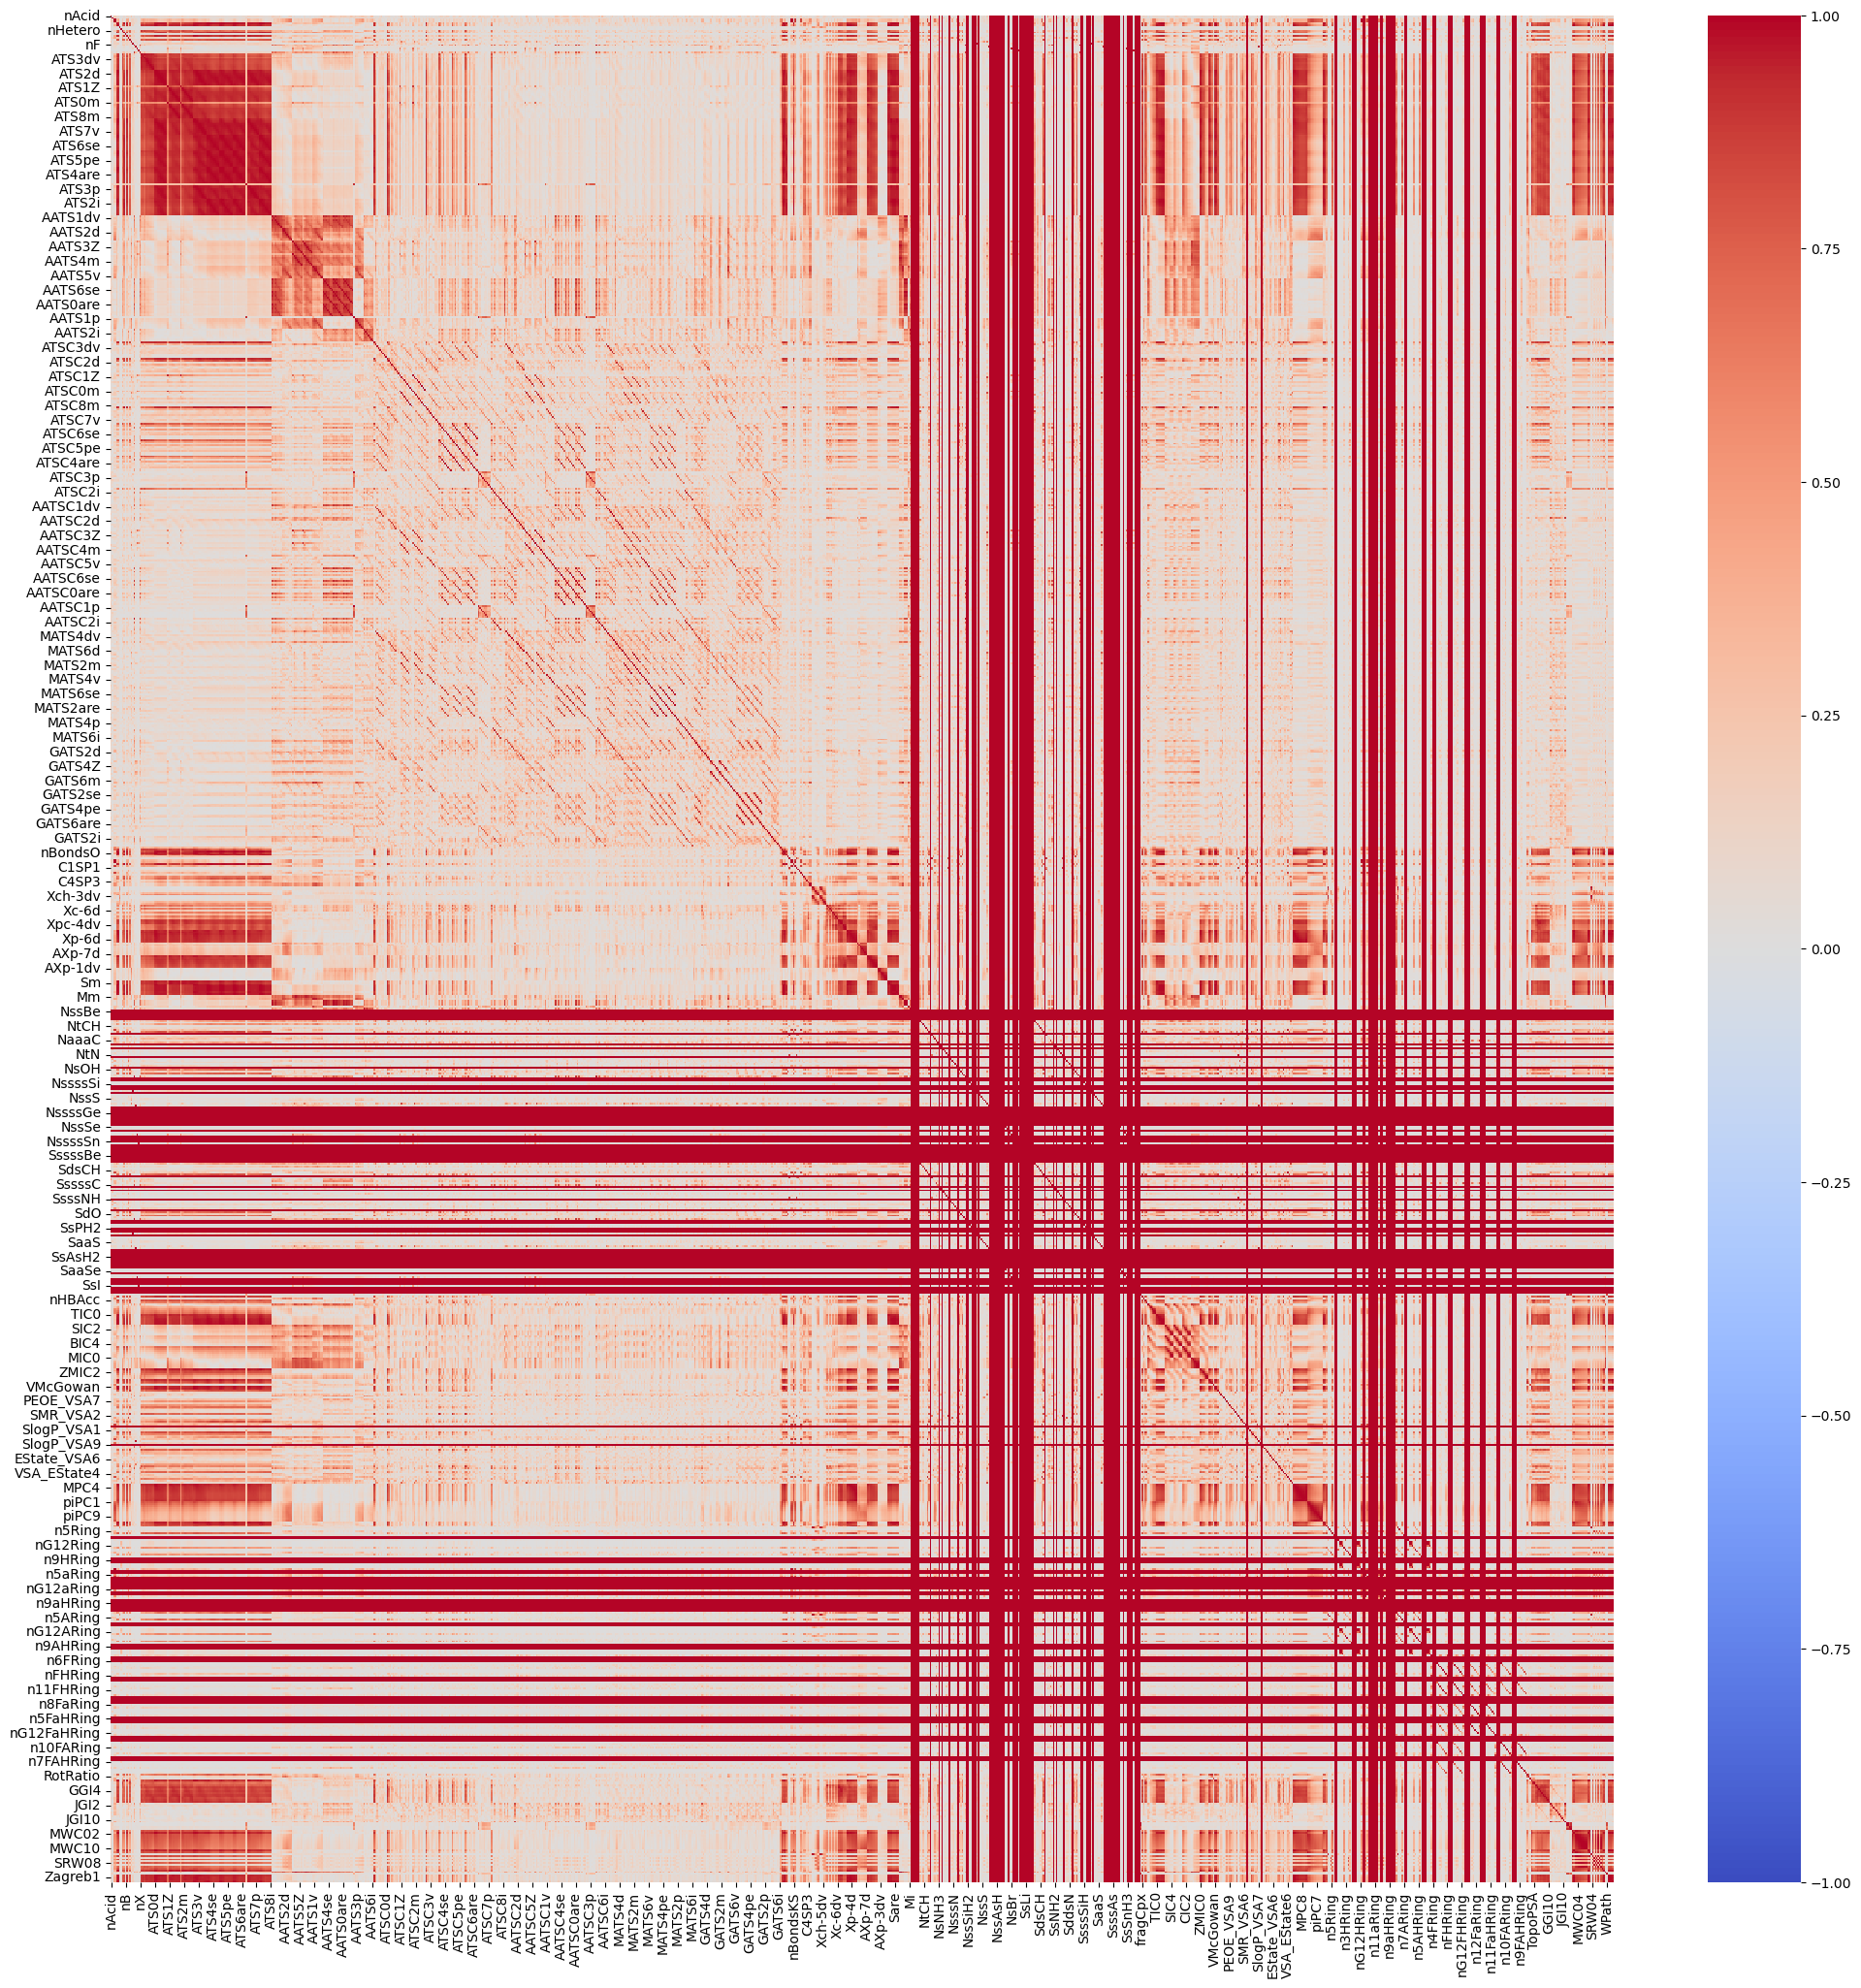

In [14]:
# Загрузка датасета

dataset = pd.read_csv('Parsing_res.csv')

# Конвертация smiles в молекулы RDKit

molecules = []
for i in range(len(dataset)):
    molecules.append(rdkit.Chem.MolFromSmiles(dataset['canonical_smiles'][i]))

# Рассчет дескрипторов с выгрузкой рассчитанных значений в отдельный файл 'Raw.csv' (чтобы не ждать по 5-6 минут раз за разом)

# После первого рассчета этот кусок кода можно выключить

'''

calc = md.Calculator(descriptors, ignore_3D=True)
        
mordred_desc = calc.pandas(molecules)

mordred_desc.info()

filtered_desc = mordred_desc.select_dtypes(exclude=['object'])

with open('Raw.csv', 'w', newline='', encoding='utf-8'):
    filtered_desc.to_csv('Raw.csv', index = False)

filtered_desc.info() 

'''

# Объединение с данными dataset и запись результата в отдельный файл 'desc_data.csv'

'''

raw_desc = pd.read_csv('Raw.csv')
desc_data = dataset.join(raw_desc)

with open('desc_data.csv', 'w', newline='', encoding='utf-8'):
    desc_data.to_csv('desc_data.csv', index = False)

raw_desc.info()

'''

# Рассчет фингерпринтов Morgan

fingerprints = []
for mol in molecules:
    fingerprints.append(AllChem.GetMorganFingerprintAsBitVect(mol, radius = 3, nBits = 2048))

# Визуализация корелляции с помощью матрицы

desc_data = pd.read_csv('desc_data.csv')

non_feature_cols = [col for col in desc_data.columns if desc_data[col].dtype == 'bool']
desc_data = desc_data.drop(columns=non_feature_cols)

desc_data.info()

corr_matrix = desc_data.iloc[:, 2:].corr().abs()

# np.inf, np.nan и -np.inf объекты типа float64

corr_matrix = corr_matrix.replace([np.inf, -np.inf, np.nan], 1)

# Отсеивание признаков с корреляцией больше 0.8

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

desc_data = desc_data.drop(columns=to_drop)

#corr_matrix = corr_matrix.replace([np.inf, -np.inf, np.nan], 1)

desc_data.info()

# Сохранение матрицы в отдельном файле 'corr_heatmap.png'

plt.figure(figsize=(25,25))
sbn.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.savefig('corr_heatmap.png')

# Сохраняем результат в очередном файле '2task_res.csv'

with open('2task_res.csv', 'w', newline='', encoding='utf-8'):
    desc_data.to_csv('2task_res.csv', index = False)